In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import tensorly as tl
import time
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colrs

import pickle as pkl

from tqdm import tqdm
import torch
import gc

from descartes.patch import PolygonPatch

from my_lib import common
import folium
from shapely.geometry import Point, mapping, box
from shapely.geometry import shape as Shape
from shapely.ops import transform as Shapely_transform

import mapply

In [2]:
tl.set_backend('pytorch')

os.environ['CUDA_DEVICE_ORDER']= 'PCI_BUS_ID' # see issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
USER = os.getlogin()
WORKING_DIR = f'/home/{USER}/data/Land_use'
DATA_DIR = f'{WORKING_DIR}/data'
IMAGE_DIR = f'{WORKING_DIR}/images'
CITY_NAME = 'Paris'

In [4]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['CMU Serif Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

In [5]:
df_mask = pd.read_pickle(f'{DATA_DIR}/df_masks.pkl')
city_row = df_mask[df_mask['name'] == CITY_NAME].iloc[0]

city_shape = city_row['shape']
city_mask = city_row['mask']
city_left_x = city_row['left_x']
city_bottom_y = city_row['bottom_y']

In [6]:
fd = open(f'{DATA_DIR}/{CITY_NAME}/{CITY_NAME}_iris_srca_tensor.pkl', 'rb')
numpy_tensor = pkl.load(fd)
numpy_tensor = numpy_tensor[0]
fd.close()

In [7]:
numpy_tensor.shape

(2800, 58, 336)

In [8]:
fd = open(f'{DATA_DIR}/considered_apps.pkl', 'rb')
apps = pkl.load(fd)
#apps = apps[0]
fd.close()

In [9]:
rank = [7,7,4]         #[5,6,4]

start_time = time.time()

tensorly_tensor = tl.tensor(numpy_tensor, device='cuda', dtype=torch.float32)
core, factors = tl.decomposition.non_negative_tucker(tensorly_tensor, rank=rank)
end_time = time.time()
delta_time = (end_time - start_time)

tensorly_tensor_approx = tl.tucker_to_tensor((core, factors))
mse_tensor = tl.metrics.regression.MSE(tensorly_tensor, tensorly_tensor_approx)
rmse_tensor = tl.metrics.regression.RMSE(tensorly_tensor, tensorly_tensor_approx)
# congruence, _ = tl.metrics.congruence_coefficient(tensorly_tensor, tensorly_tensor_approx)

numpy_tensor_approx = tensorly_tensor_approx.cpu().numpy()
l2_norm_error = np.linalg.norm(numpy_tensor - numpy_tensor_approx)

print(f'{rank[0]}\t{rank[1]}\t{rank[2]}\t{delta_time:.2f}\t{mse_tensor:.4f}\t{rmse_tensor:.4f}\t{l2_norm_error:.4f}')

7	7	4	2.60	0.0996	0.3156	2331.2760


In [10]:
space_factor = factors[0].cpu().numpy()
app_factor = factors[1].cpu().numpy()
time_factor = factors[2].cpu().numpy()
space_factor.shape

(2800, 7)

In [11]:
# np.save(f'{DATA_DIR}/time_factors_ranks_{rank[0]}{rank[1]}{rank[2]}', time_factor, allow_pickle=True)
# np.save(f'{DATA_DIR}/app_factors_ranks_{rank[0]}{rank[1]}{rank[2]}', app_factor, allow_pickle=True)
# np.save(f'{DATA_DIR}/space_factors_ranks_{rank[0]}{rank[1]}{rank[2]}', space_factor, allow_pickle=True)

In [12]:
# import numpy as np
# import os
# import matplotlib.pyplot as plt

# USER = os.getlogin()
# WORKING_DIR = f'/home/{USER}/data/Land_use'
# DATA_DIR = f'{WORKING_DIR}/data'

# rank = [5, 5, 4]

# time_factor = np.load(f'{DATA_DIR}/time_factors_ranks_{rank[0]}{rank[1]}{rank[2]}.npy', allow_pickle=True)
# space_factor = np.load(f'{DATA_DIR}/space_factors_ranks_{rank[0]}{rank[1]}{rank[2]}.npy', allow_pickle=True)
# app_factor = np.load(f'{DATA_DIR}/app_factors_ranks_{rank[0]}{rank[1]}{rank[2]}.npy', allow_pickle=True)
# space_factor.shape, app_factor.shape, time_factor.shape

### Time Factors

In [11]:
list_time = []
for i in range(0,48):
    hour = int(i/2)
    hour = f"{hour:02}" # add leading zero
    if i%2 == 0:
        minute = '00'
    else:
        minute = '30'
    list_time.append(f'{hour}:{minute}')



In [13]:
def show_time_factors(factor_matrix, list_ranks):   # tuple_ranks = (space, app, time)
    global_min_value = np.min(factor_matrix)
    global_max_value = np.max(factor_matrix)
    print(global_min_value, global_max_value)

    my_cmap = plt.cm.RdBu_r
    my_norm = plt.cm.colors.TwoSlopeNorm(vmin=global_min_value, vmax=global_max_value/2, vcenter=0)

    labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    fig = plt.figure(figsize=(20,40))
    #fig.suptitle(f'TimeFactor_rank_545')
    list_axes = []

    for i in range(0, list_ranks[2]):
        #time_factor_i = time_factor_loaded[:,i]
        time_factor_i = time_factor[:,i]
        reshaped_time_factor_i = time_factor_i.reshape(7,48)
        labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        x = list(range(0,48))
        
        ax = fig.add_subplot(list_ranks[2], 1, i+1)
        list_axes.append(ax)
        ax.imshow(reshaped_time_factor_i, cmap=my_cmap, interpolation='nearest', aspect='auto', norm = my_norm)
        ax.set_xticks(x)
        ax.set_xticklabels(list_time, rotation=90)
        ax.set_yticks(range(0,7))
        ax.set_yticklabels(labels)
        ax.set_title(f'Time Factor_{i}_rank_{list_ranks[0]}{list_ranks[1]}{list_ranks[2]}')

    plt.colorbar(plt.cm.ScalarMappable(cmap=my_cmap, norm= my_norm), ax=list_axes)
    plt.show()
    


show_time_factors(time_factor, rank)

1.5904037e-13 5.078303


ValueError: vmin, vcenter, and vmax must be in ascending order

In [15]:
# global_min_value = np.min(time_factor)
# global_max_value = np.max(time_factor)
# my_cmap = plt.cm.RdBu_r
# my_norm = plt.cm.colors.TwoSlopeNorm(vmin=global_min_value, vmax=global_max_value/2, vcenter=0)
# plt.colorbar(plt.cm.ScalarMappable(cmap=my_cmap, norm= my_norm))#, ax=list_axes)
# plt.show()

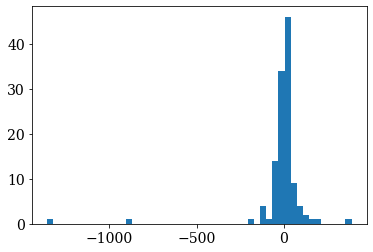

In [16]:
core_np = core.cpu().numpy()
core_values = core_np.flatten()
core_values_sorted = sorted(core_values, reverse=True)
plt.hist(core_values, bins=50)
plt.show()

In [17]:
print(core_values_sorted[0:10])

[385.90372, 183.10062, 151.02371, 118.83652, 115.726036, 106.186066, 84.173836, 82.422, 78.29926, 62.700897]


In [18]:
print("Rank order is (Space, App, Time)")
for i in range(0,10):
    print(np.where(core.cpu().numpy() == core_values_sorted[i]))


Rank order is (Space, App, Time)
(array([2]), array([2]), array([0]))
(array([3]), array([4]), array([0]))
(array([1]), array([1]), array([1]))
(array([1]), array([5]), array([1]))
(array([0]), array([2]), array([1]))
(array([2]), array([0]), array([1]))
(array([3]), array([3]), array([0]))
(array([1]), array([2]), array([1]))
(array([4]), array([4]), array([0]))
(array([1]), array([4]), array([2]))


In [19]:
# core.cpu().numpy()[3,3,0]

### App Factors

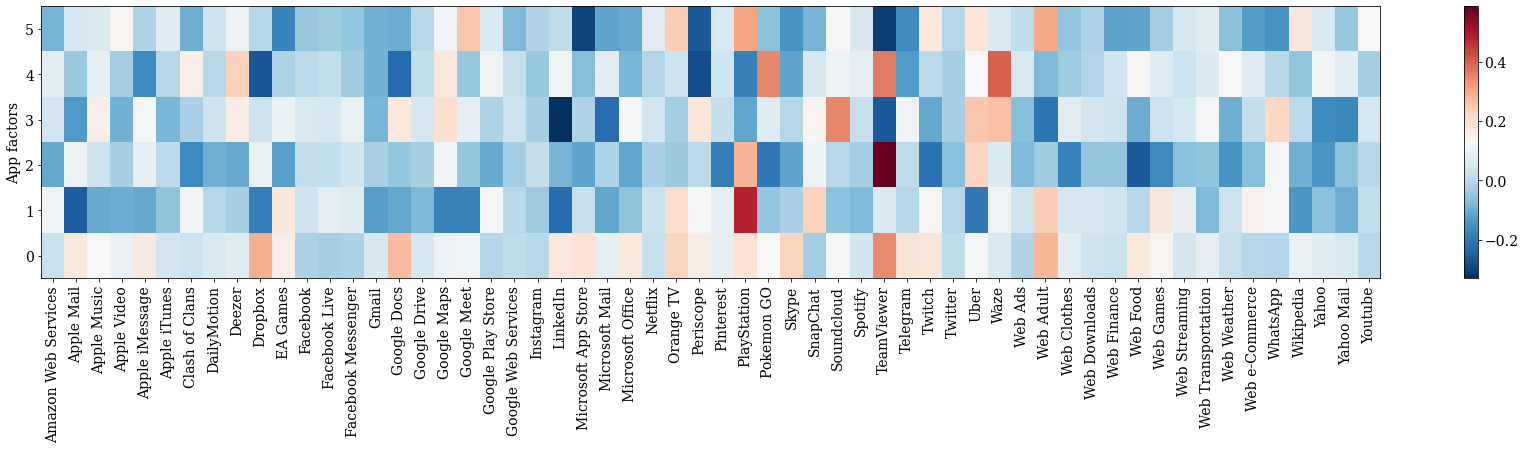

In [20]:
v_min = app_factor.min()
v_max = app_factor.max()
my_norm = plt.cm.colors.TwoSlopeNorm(vmin=v_min, vmax=v_max, vcenter=0)
plt.figure(figsize=(30, 5))
plt.imshow(app_factor.T, cmap = 'RdBu_r', origin='lower', aspect='auto')
plt.xticks(range(len(apps)), apps, rotation=90)
plt.yticks(range(0, rank[1]))
plt.ylabel('App factors')
plt.colorbar()
plt.show()


In [21]:
# np.where(loading_slice == max(loading_slice.flatten()))

#### Plot slice of core tensor

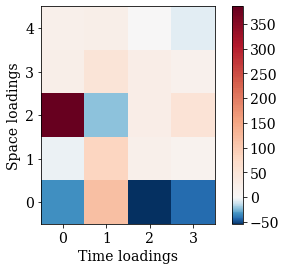

In [22]:
loading_slice = core_np[:,2,:]
global_min_value = np.min(loading_slice)
global_max_value = np.max(loading_slice)
my_cmap = plt.cm.RdBu_r
my_norm = plt.cm.colors.TwoSlopeNorm(vmin=global_min_value, vmax=global_max_value, vcenter=0)

plt.imshow(loading_slice,cmap = my_cmap, norm = my_norm, origin='lower')
plt.colorbar(plt.cm.ScalarMappable(cmap=my_cmap, norm= my_norm))
plt.ylabel('Space loadings')
plt.xlabel('Time loadings')

plt.show()

In [70]:
# list_of_time_factors_to_plot = [ 2, 3]

# x = list(range(0,48))   # 48 because half hourly data
# labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


# fig = plt.figure(figsize=(20,10))
# for i in list_of_time_factors_to_plot:
#     plt.plot(time_factor[:,i], label=f'Factor_{i}')

# ticks = list(range(0,336, 4))
# ticks_labels = list_time[::4]*7
# plt.xticks(ticks, ticks_labels, rotation=90)

# #plt.xticks(x, list_time, rotation=90)
# for i in range(0,336,48):
#     plt.axvline(x=i, color='y', linestyle='--')
#     #plt.text(i, 0, str(i), rotation=90, verticalalignment='bottom')

# plt.xlim(0,336)
# plt.legend()    
# plt.show()

### Space Factors

In [83]:
df_iris = pd.read_pickle(f'{DATA_DIR}/cell_iris_ratio/df_ratio_{CITY_NAME}.pkl')
df_iris.drop_duplicates(subset=['iris_index'], inplace=True)
df_iris.reset_index(drop=True, inplace=True)
df_iris.head()

iris_index  iris_code  cell_id     ratio   
0           0  920440109    95256  0.013668  \
1           1  930270105   105030  0.217313   
2           2  751197316    94281  0.029211   
3           3  751176716    93193  0.340376   
4           4  920020104    44410  0.114022   

                                            geometry  
0  POLYGON ((48.89379 2.29154, 48.89362 2.29113, ...  
1  POLYGON ((48.92059 2.41055, 48.91992 2.40987, ...  
2  POLYGON ((48.89133 2.37225, 48.89141 2.37228, ...  
3  POLYGON ((48.88784 2.30708, 48.88828 2.30651, ...  
4  POLYGON ((48.76094 2.31324, 48.76135 2.31085, ...

In [90]:
space_factor_to_plot = 2
one_space_factor = list(space_factor[:,space_factor_to_plot])
len(one_space_factor)

2800

In [91]:
df_iris['space_factor'] = one_space_factor
df_iris.head()

iris_index  iris_code  cell_id     ratio   
0           0  920440109    95256  0.013668  \
1           1  930270105   105030  0.217313   
2           2  751197316    94281  0.029211   
3           3  751176716    93193  0.340376   
4           4  920020104    44410  0.114022   

                                            geometry  space_factor  
0  POLYGON ((48.89379 2.29154, 48.89362 2.29113, ...     -0.022939  
1  POLYGON ((48.92059 2.41055, 48.91992 2.40987, ...      0.035948  
2  POLYGON ((48.89133 2.37225, 48.89141 2.37228, ...     -0.000845  
3  POLYGON ((48.88784 2.30708, 48.88828 2.30651, ...     -0.010578  
4  POLYGON ((48.76094 2.31324, 48.76135 2.31085, ...     -0.034069

In [66]:
# convert to gepandas
# df_iris = gpd.GeoDataFrame(df_iris, crs='EPSG:4326', geometry="geometry")

# df_iris.plot(column='space_factor', cmap='RdBu_r', legend=True, figsize=(20,10))

# convert geopandas to geojson
# df_iris_json = df_iris.__geo_interface__

# df_iris_json

0.05908534675836563 -0.046389296650886536


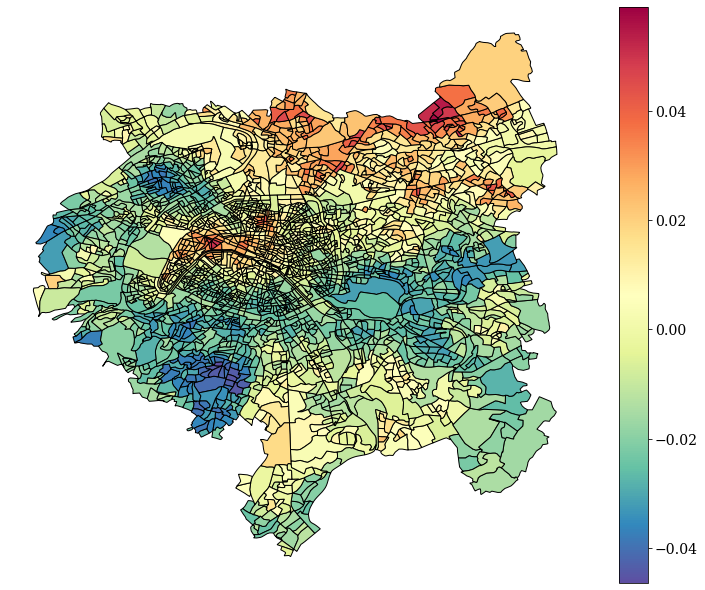

In [92]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0, 0, 1, 1])

iris_shapes = list(df_iris['geometry'])
space_factor_ = list(df_iris['space_factor'])
print(max(space_factor_), min(space_factor_))
my_cmap = plt.cm.Spectral_r
my_norm = colrs.Normalize(vmin=min(space_factor_), vmax=max(space_factor_))

for iris_shape, space_factor_ in zip(iris_shapes, space_factor_):
    iris_shape_to_plot = Shapely_transform(lambda x,y: (y, x), iris_shape)

    color = my_cmap(my_norm(space_factor_))

    patch = PolygonPatch(iris_shape_to_plot, fc=color, alpha=1, zorder=2)
    ax.add_patch(patch)

plt.autoscale(True)
plt.axis('off')
plt.colorbar(plt.cm.ScalarMappable(cmap=my_cmap, norm=my_norm))
plt.show()

In [93]:
def get_map(init_location=[46.2276, 2.2137], 
            zoom_start=10, 
            zoom_control=False,
            style='light'):

    styles = {
    'light': 'mapbox/light-v9',
    'dark': 'mapbox/dark-v9',
    'streets': 'mapbox/streets-v11',
    }
    if style not in styles:
        raise ValueError('Style not supported')
    style = styles[style]

    m = folium.Map(location=init_location, zoom_control=zoom_control, zoom_start=zoom_start, 
                    tiles=f'https://api.mapbox.com/styles/v1/{style}/tiles/{{z}}/{{x}}/{{y}}?access_token=pk.eyJ1Ijoia3ViYS1yZWlzZW4iLCJhIjoiY2p5NjNkMjRhMGU3bDNkc3l1OWI3OXl0byJ9.m5V748nSYU5KWdQ8MchSSQ', attr='Mapbox')

    return m


In [95]:
m = get_map(init_location=[48.89379, 2.29154], zoom_start=12, style='light')

folium.Polygon(mapping(city_shape)['coordinates'][0],
    color='lightblue',
    fill_color='lightblue',
    opacity = 1,
    fill_opacity = .01,
    weight=5,
    ).add_to(m)


# geojson = common.get_contourf(app_traffic_at_time, city_left_x, city_bottom_y, my_cmap_space_factor, norm_space_factor, levels=10)
v_min = df_iris['space_factor'].min()
v_max = df_iris['space_factor'].max()
# my_cmap = plt.cm.Spectral_r
# my_norm = colrs.Normalize(vmin=v_min, vmax=v_max)
my_cmap = plt.cm.RdBu_r
my_norm = plt.cm.colors.TwoSlopeNorm(vmin=v_min, vmax=v_max, vcenter=0)
for row in df_iris.to_dict('records'):
    geometry = row['geometry']
    space_factor__ = row['space_factor']
    color = my_cmap(my_norm(space_factor__))
    color = colrs.to_hex(color)
    folium.Polygon(mapping(geometry)['coordinates'][0],
        color=color,
        fill_color=color,
        opacity = 0.1,
        fill_opacity = .4,
        weight=1,
        # tooltip=f"{space_factor__:.3f}",
    ).add_to(m)



m

In [75]:
np.array(one_space_factor).shape

(2800,)

In [76]:
n_cols = p_l_t.shape[1]
n_rows = p_l_t.shape[0]
xs = [xllcorner+i*100 for i in range(n_cols)]
ys = [yllcorner+i*100 for i in range(n_rows)]

# use fig to capture the output, and close it to avoid display
fig = plt.figure(figsize=(2,2 ))
contourf = plt.contourf(xs, ys, p_l_t, cmap=cmap, norm=norm, levels=levels)

NameError: name 'p_l_t' is not defined